In [1]:
import pandas as pd
import json
import numpy as np
import operator
import matplotlib.pyplot as plt
from collections import Counter
import os
import time
import pickle
import networkx as nx
import string

pd.options.mode.chained_assignment = None  # default='warn'

ROOT = os.path.dirname(os.getcwd())
teams = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'teams.pkl.gz'))
players = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'players.pkl.gz'))
players['shortName'] = players['shortName'].apply(lambda s: ''.join([x for x in s if x.isalpha() or x in [' ', '.'] ]))
player_mapping = {row['wyId'] : row['shortName'] for i, row in players.iterrows()}
players

,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,...,passportArea.id,passportArea.alpha3code,passportArea.alpha2code,role.code2,role.code3,role.name,birthArea.name,birthArea.id,birthArea.alpha3code,birthArea.alpha2code
0,78,Harun,,Tekin,4502,1989-06-17,187,32777,right,H. Tekin,...,792,TUR,TR,GK,GKP,Goalkeeper,Turkey,792,TUR,TR
1,73,Malang,,Sarr,3775,1999-01-23,182,393228,left,M. Sarr,...,686,SEN,SN,DF,DEF,Defender,France,250,FRA,FR
2,72,Over,,Mandanda,3772,1998-10-26,176,393230,,O. Mandanda,...,250,FRA,FR,GK,GKP,Goalkeeper,France,250,FRA,FR
3,82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,32793,right,A. NDiaye,...,686,SEN,SN,MD,MID,Midfielder,France,250,FRA,FR
4,84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,393247,right,I. Konatue,...,250,FRA,FR,DF,DEF,Defender,France,250,FRA,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,72,Ali,,Ma\u00e2loul,16041,1990-01-01,175,120839,left,A. Maueloul,...,788,TUN,TN,DF,DEF,Defender,Tunisia,788,TUN,TN
3599,76,Carlos Alberto,,C\u00e1ceda Oyaguez,15591,1991-09-27,183,114736,right,C. Cueceda,...,604,PER,PE,GK,GKP,Goalkeeper,Peru,604,PER,PE
3600,78,Miguel Gianpierre,,Araujo Blanco,12072,1994-10-24,179,114908,right,M. Araujo,...,604,PER,PE,DF,DEF,Defender,Peru,604,PER,PE
3601,70,Ahmed Reda,,Tagnaouti,16183,1996-04-05,182,285583,right,A. Tagnaouti,...,504,MAR,MA,GK,GKP,Goalkeeper,Morocco,504,MAR,MA


# Background:
Look at player netowrk graphs and extract clustering coefficient and centrality metrics


## Per game passing volume (w)

In [2]:
events = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'events_df.pkl.gz'))
events_passing = events.loc[events['eventName']=='Pass']
events_passing.head(5)

eventId subEventName            tags  playerId  \
Italy 0         8  Simple pass  [{'id': 1801}]      8327   
      1         8  Simple pass  [{'id': 1801}]     20438   
      5         8  Simple pass  [{'id': 1801}]      8306   
      10        8  Simple pass  [{'id': 1801}]     86366   
      14        8  Simple pass  [{'id': 1801}]      8306   

                                         positions  matchId eventName  teamId  \
Italy 0   [{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]  2575959      Pass    3158   
      1   [{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]  2575959      Pass    3158   
      5   [{'y': 15, 'x': 72}, {'y': 25, 'x': 72}]  2575959      Pass    3158   
      10  [{'y': 82, 'x': 38}, {'y': 88, 'x': 43}]  2575959      Pass    3172   
      14  [{'y': 15, 'x': 61}, {'y': 15, 'x': 37}]  2575959      Pass    3158   

         matchPeriod   eventSec subEventId         id  
Italy 0           1H   2.530536         85  180423957  
      1           1H   3.768418         85  180423958  
      5           1H  10.376066         85  180423962  
      10          1H  16.240563         85  180423979  
      14          1H  19.153235         85  180423968

In [3]:
w = events_passing.groupby(['matchId', 'teamId']).count().mean(axis=1).to_frame('w').sort_index() #Dont really need the mean, all cols are the same anyways
w.head()

w
matchId teamId       
2499719 1609    606.0
        1631    230.0
2499720 1625    754.0
        1651    184.0
2499721 1610    516.0

## Passing profile amoungst players each game


### First Lets Try Making Passing Networks
**Naive Assumption:** A pass X from player i is to player j if player j initiates the next recorded pass after X. This may be violated for turnovers, fouls, and out-of-play stoppages.

The network is such that each plaer is a node, and directed edges from node i to node j are proportional in magnitude to the passing frequency from player i to player j

In [4]:
matchId = 2499939

#Get the time for the latest event in the first half for this match
end_first_half = events.loc[(events['matchId']==matchId)
                            &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


df = events_passing.loc[(events_passing['matchId']==matchId)]
df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
df = df[['playerId', 'positions', 'teamId', 'time']]


team1, team2 = df['teamId'].unique()
profile_team1 = df.loc[df['teamId'] == team1, ['playerId', 'time']].sort_values(by='time').reset_index(drop=True)
profile_team2 = df.loc[df['teamId'] == team2, ['playerId', 'time']].sort_values(by='time').reset_index(drop=True)


#Filter to players that have played at least 50 minutes of football to reduce outlier effects
player_time = (profile_team1.groupby('playerId').max() - profile_team1.groupby('playerId').min())
#relevant_players = player_time.loc[player_time['time']>3000].index
#profile_team1 = profile_team1.loc[profile_team1['playerId'].isin(relevant_players)]

player_time = (profile_team2.groupby('playerId').max() - profile_team2.groupby('playerId').min())
#relevant_players = player_time.loc[player_time['time']>3000].index
#profile_team2 = profile_team2.loc[profile_team2['playerId'].isin(relevant_players)]



# Naive assumption: Receiver is the player who made the next pass in this team - doesn't account for interceptions
# We will make a graph with edge (i, j) value = Number of passes from player i to player j
profile_team1['sender'] = profile_team1['playerId']
profile_team1['receiver'] = profile_team1['playerId'].shift(-1).dropna()
profile_team1 = profile_team1[['sender', 'receiver']]
profile_team1 = profile_team1.loc[profile_team1['sender'] != profile_team1['receiver']]
profile_team1 = profile_team1.groupby(['sender','receiver']).size().to_frame('weight').reset_index().astype(int)

profile_team2['sender'] = profile_team2['playerId']
profile_team2['receiver'] = profile_team2['playerId'].shift(-1).dropna()
profile_team2 = profile_team2[['sender', 'receiver']]
profile_team2 = profile_team2.loc[profile_team2['sender'] != profile_team2['receiver']]
profile_team2 = profile_team2.groupby(['sender','receiver']).size().to_frame('weight').reset_index().astype(int)


### Vizualization

Arsenal
density = 0.7756410256410257


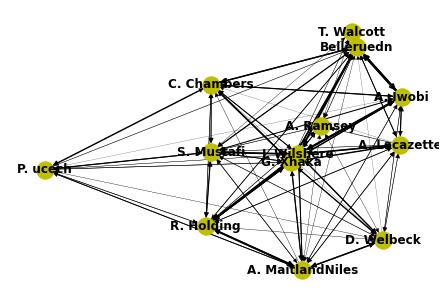

Arsenal: mean = 0.8264462809917356 ; std = 0.6192236823542223 ; count = 493




AFC Bournemouth
density = 0.6318681318681318


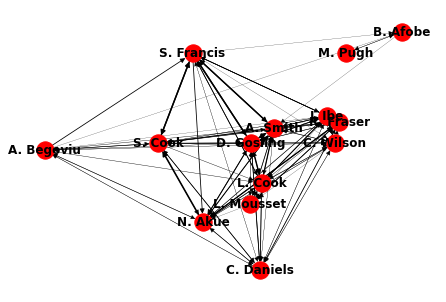

AFC Bournemouth: mean = 0.8695652173913043 ; std = 0.5674027506955998 ; count = 315


In [5]:
#Avg position/player
player_positions = events.loc[(events['matchId']==matchId)]
player_positions['x'] = player_positions['positions'].apply(lambda l: l[0]['x'])
player_positions['y'] = player_positions['positions'].apply(lambda l: l[0]['y'])
player_positions = player_positions[['x', 'y', 'playerId']].groupby(df['playerId'])[['x', 'y']].mean()
player_positions = player_positions.join(pd.Series(player_mapping, name='name'))

positions1 = player_positions.loc[player_positions.index.isin(profile_team1['sender'].unique())]
positions1 = {row['name'] : (row['x'], row['y']) for i, row in positions1.iterrows()}

positions2 = player_positions.loc[player_positions.index.isin(profile_team2['sender'].unique())]
positions2 = {row['name'] : (row['x'], row['y']) for i, row in positions2.iterrows()}


#team and player names
team1, team2 = teams.loc[teams['wyId']==team1,'name'].values[0], teams.loc[teams['wyId']==team2,'name'].values[0]

g = nx.DiGraph()
g.add_edges_from([(row['sender'], row['receiver'], {'weight':row['weight']}) for i, row in profile_team1.iterrows()])
g = nx.relabel_nodes(g, player_mapping)
nx.draw(g, positions1, with_labels=True, font_weight='bold', node_color = 'y', width=[g[u][v]['weight']/5 for u, v in g.edges()])
print (team1)
#print ('centrality =', nx.global_reaching_centrality(g))
#print ('algebric connectivity =', nx.algebraic_connectivity(g))
print ('density =', nx.density(g))
plt.show()
print ('%s: mean ='%team1, profile_team1['weight'].mean()/profile_team1['weight'].sum()*100,
       '; std =', profile_team1['weight'].std()/profile_team1['weight'].sum()*100,
       '; count =', profile_team1['weight'].sum())

print('\n\n\n')

g = nx.DiGraph()
g.add_edges_from([(row['sender'], row['receiver'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
g = nx.relabel_nodes(g, player_mapping)
nx.draw(g, positions2, with_labels=True, font_weight='bold', node_color='r', width=[g[u][v]['weight']/5 for u, v in g.edges()])
print (team2)
#print ('centrality =', nx.global_reaching_centrality(g))
#print ('algebric connectivity =', nx.algebraic_connectivity(g))
print ('density =', nx.density(g))
plt.show()
print ('%s: mean ='%team2, profile_team2['weight'].mean()/profile_team2['weight'].sum()*100,
       '; std =', profile_team2['weight'].std()/profile_team2['weight'].sum()*100,
       '; count =', profile_team2['weight'].sum())

## What can we even get from these graphs?

### Clustering Coefficient

In [6]:
display(pd.Series(nx.clustering(g)))
display(pd.Series(nx.clustering(g)).mean())

D. Gosling    0.800000
A. Smith      0.753394
A. Begoviu    0.840000
S. Cook       0.895062
S. Francis    0.839041
C. Daniels    0.888889
J. Ibe        0.872928
C. Wilson     0.865031
R. Fraser     0.851852
N. Akue       0.856354
L. Mousset    0.976190
L. Cook       0.877301
B. Afobe      0.222222
M. Pugh       0.000000
dtype: float64

0.7527330703497601

In [7]:
def topological_all_pairs_shortest_paths(g_in):
    g = g_in.copy()

    for u, v in g.edges():
        g[u][v]['weight'] = 1/g[u][v]['weight']

    shortest_paths = dict(nx.algorithms.shortest_paths.weighted.all_pairs_dijkstra(g))
    shortest_paths = [list(shortest_paths[k][0].values()) for k in shortest_paths.keys()]
    mean = pd.Series([elem for sublist in shortest_paths for elem in sublist]).replace(0, np.nan).mean()
    return mean

In [8]:
nx.algebraic_connectivity(g.to_undirected())

0.7757138943144014

In [9]:
topological_all_pairs_shortest_paths(g)

0.7385923600209314

# Streamlining the process

In [10]:
matches = w.index.get_level_values(0).unique(); n=len(matches)
network_stats = dict()



for i, match in enumerate(matches):
    if i % 50 == 0: print('{}/{}'.format(i, n))
    
    matchId = match

    #Get the time for the latest event in the first half for this match
    end_first_half = events.loc[(events['matchId']==matchId)
                                &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


    df = events_passing.loc[(events_passing['matchId']==matchId)]
    df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
    df = df[['playerId', 'positions', 'teamId', 'time']]


    team1, team2 = df['teamId'].unique()
    profile_team1 = df.loc[df['teamId'] == team1, ['playerId', 'time']].sort_values(by='time').reset_index(drop=True)
    profile_team2 = df.loc[df['teamId'] == team2, ['playerId', 'time']].sort_values(by='time').reset_index(drop=True)
    
    #Saving Stats as dict of dicts
    network_stats[match] = dict()
    network_stats[match][team1], network_stats[match][team2] = dict(), dict() 


    #Filter to players that have played at least 50 minutes of football to reduce outlier effects
    player_time = (profile_team1.groupby('playerId').max() - profile_team1.groupby('playerId').min())
    #relevant_players = player_time.loc[player_time['time']>3000].index
    #profile_team1 = profile_team1.loc[profile_team1['playerId'].isin(relevant_players)]

    player_time = (profile_team2.groupby('playerId').max() - profile_team2.groupby('playerId').min())
    #relevant_players = player_time.loc[player_time['time']>3000].index
    #profile_team2 = profile_team2.loc[profile_team2['playerId'].isin(relevant_players)]



    # Naive assumption: Receiver is the player who made the next pass in this team - doesn't account for interceptions
    # We will make a graph with edge (i, j) value = Number of passes from player i to player j
    profile_team1['sender'] = profile_team1['playerId']
    profile_team1['receiver'] = profile_team1['playerId'].shift(-1).dropna()
    profile_team1 = profile_team1[['sender', 'receiver']]
    profile_team1 = profile_team1.loc[profile_team1['sender'] != profile_team1['receiver']]
    profile_team1 = profile_team1.groupby(['sender','receiver']).size().to_frame('weight').reset_index().astype(int)

    profile_team2['sender'] = profile_team2['playerId']
    profile_team2['receiver'] = profile_team2['playerId'].shift(-1).dropna()
    profile_team2 = profile_team2[['sender', 'receiver']]
    profile_team2 = profile_team2.loc[profile_team2['sender'] != profile_team2['receiver']]
    profile_team2 = profile_team2.groupby(['sender','receiver']).size().to_frame('weight').reset_index().astype(int)

    g = nx.DiGraph()
    g.add_edges_from([(row['sender'], row['receiver'], {'weight':row['weight']}) for i, row in profile_team1.iterrows()])
    df = pd.Series(dict(g.degree(weight='weight')), name='number_passes_invloved')
    network_stats[match][team1]['avg_clustering_coefficient'] = pd.Series(nx.clustering(g)).mean()
    network_stats[match][team1]['algebraic_connectivity'] = nx.algebraic_connectivity(g.to_undirected())
    network_stats[match][team1]['avg_shortest_path_all_pairs'] = topological_all_pairs_shortest_paths(g)
    #network_stats[match][team1]['mean_passes_players'] = df.mean()
    #network_stats[match][team1]['std_passes_players'] = df.std()
    
    g = nx.DiGraph()
    g.add_edges_from([(row['sender'], row['receiver'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
    df = pd.Series(dict(g.degree(weight='weight')), name='number_passes_invloved')
    network_stats[match][team2]['avg_clustering_coefficient'] = pd.Series(nx.clustering(g)).mean()
    network_stats[match][team2]['algebraic_connectivity'] = nx.algebraic_connectivity(g.to_undirected())
    network_stats[match][team2]['avg_shortest_path_all_pairs'] = topological_all_pairs_shortest_paths(g)
    #network_stats[match][team2]['mean_passes_players'] = df.mean()
    #network_stats[match][team2]['std_passes_players'] = df.std()
    
    
    
network_stats = pd.DataFrame.from_dict({(i,j): network_stats[i][j] 
                           for i in network_stats.keys() 
                           for j in network_stats[i].keys()},
                       orient='index')
network_stats

0/1826
50/1826
100/1826
150/1826
200/1826
250/1826
300/1826
350/1826
400/1826
450/1826
500/1826
550/1826
600/1826
650/1826
700/1826
750/1826
800/1826
850/1826
900/1826
950/1826
1000/1826
1050/1826
1100/1826
1150/1826
1200/1826
1250/1826
1300/1826
1350/1826
1400/1826
1450/1826
1500/1826
1550/1826
1600/1826
1650/1826
1700/1826
1750/1826
1800/1826


avg_clustering_coefficient  algebraic_connectivity  \
2499719 1609                    0.805885                3.171076   
        1631                    0.718061                4.094515   
2499720 1625                    0.832531                7.381093   
        1651                    0.610426                2.994099   
2499721 1646                    0.766853                2.085549   
...                                  ...                     ...   
2576336 3158                    0.848207                7.233542   
2576337 3164                    0.825926                9.289165   
        3204                    0.797373               13.464276   
2576338 3193                    0.827287               13.568388   
        3185                    0.699476                6.868418   

              avg_shortest_path_all_pairs  
2499719 1609                     0.469193  
        1631                     0.772259  
2499720 1625                     0.296974  
        1651                     0.773443  
2499721 1646                     0.623560  
...                                   ...  
2576336 3158                     0.440867  
2576337 3164                     0.393827  
        3204                     0.410330  
2576338 3193                     0.321884  
        3185                     0.510570  

[3652 rows x 3 columns]

In [22]:
network_stats.to_pickle(os.path.join(ROOT, 'intermediates', 'player_network_algorithms.pkl.gz'))
network_stats.to_csv(os.path.join(ROOT, 'intermediates', 'player_network_algorithms.csv'))

# Analysis

In [34]:
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
tmp = pd.concat([network_stats.mean(level=1), performance], axis=1)
errors = network_stats.groupby(network_stats.index.get_level_values(1)).sem()
tmp

,avg_clustering_coefficient,algebraic_connectivity,avg_shortest_path_all_pairs,name,city,area.name,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
674,0.771043,5.447000,0.510268,Valencia,Valencia,Spain,413.789474,11.000000,1.421053,73
675,0.819420,8.783897,0.363214,Real Madrid,Madrid,Spain,581.078947,16.605263,2.131579,76
676,0.817547,6.727759,0.353586,Barcelona,Barcelona,Spain,612.105263,13.210526,2.289474,93
677,0.775735,6.074758,0.516265,Deportivo La Coru\u00f1a,A Coru\u00f1a,Spain,382.605263,10.657895,0.921053,29
678,0.801299,7.054701,0.494747,Athletic Club,Bilbao,Spain,395.315789,9.921053,0.842105,43
...,...,...,...,...,...,...,...,...,...,...
3795,0.763705,5.228793,0.549153,Troyes,Troyes,France,360.605263,8.578947,0.710526,33
3799,0.772707,4.684405,0.519319,Angers,Angers,France,379.105263,10.736842,0.947368,43
3804,0.786959,4.877720,0.536130,Dijon,Dijon,France,390.131579,10.368421,1.236842,46
10531,0.769899,4.958512,0.534603,Swansea City,Swansea,England,390.578947,8.000000,0.684211,33


,avg_clustering_coefficient,end_of_season_pts
avg_clustering_coefficient,1.00000,0.51718
end_of_season_pts,0.51718,1.00000


<Figure size 1080x360 with 0 Axes>

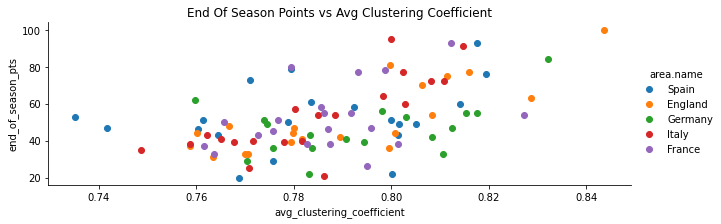

<Figure size 432x288 with 0 Axes>

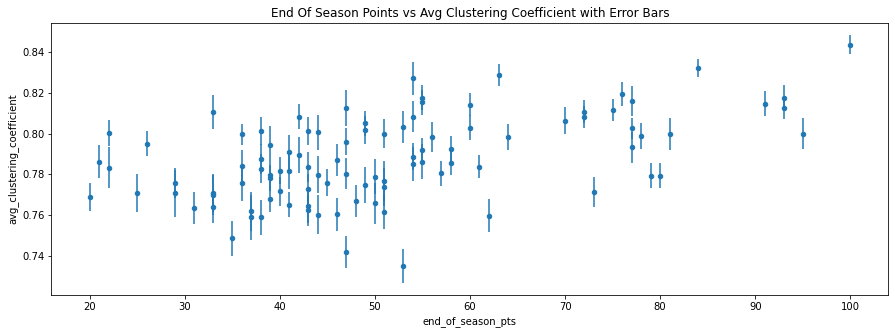

In [61]:
import seaborn
from matplotlib import pyplot 
#from ggplot import *

display(tmp[['avg_clustering_coefficient', 'end_of_season_pts']].corr())

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'avg_clustering_coefficient', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points vs Avg Clustering Coefficient')
#plt.text(.3, 0.5,'$\\rho$=0.52', fontsize=18)
plt.savefig('../figures/player_network_alg/clustering_coefficient_performance_EOS_pts', bbox_inches='tight')
plt.show()

plt.figure()
tmp[['avg_clustering_coefficient', 'end_of_season_pts']].plot(kind='scatter', x='end_of_season_pts', y='avg_clustering_coefficient', yerr=errors[['avg_clustering_coefficient']], figsize=(15, 5))
plt.title('End Of Season Points vs Avg Clustering Coefficient with Error Bars')
plt.savefig('../figures/player_network_alg/clustering_coefficient_performance_EOS_pts_ERROR', bbox_inches='tight')

plt.show()


,algebraic_connectivity,end_of_season_pts
algebraic_connectivity,1.000000,0.556497
end_of_season_pts,0.556497,1.000000


<Figure size 1080x360 with 0 Axes>

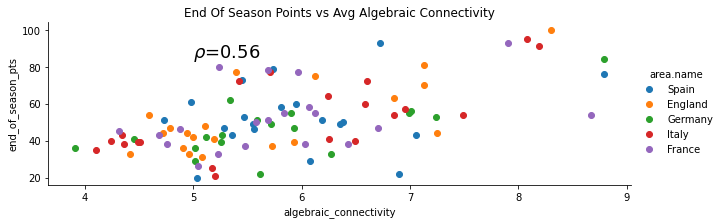

<Figure size 432x288 with 0 Axes>

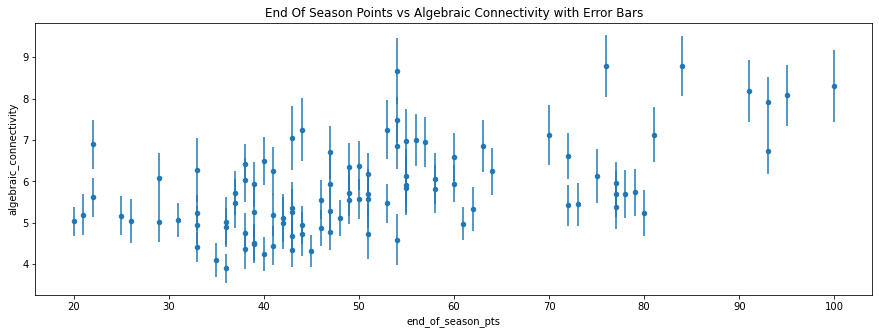

In [56]:
display(tmp[['algebraic_connectivity', 'end_of_season_pts']].corr())

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'algebraic_connectivity', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points vs Avg Algebraic Connectivity')
plt.text(5, 85,'$\\rho$=0.56', fontsize=18)
plt.savefig('../figures/player_network_alg/algebraic_connectivity_performance_EOS_pts', bbox_inches='tight')
plt.show()

plt.figure()
tmp[['algebraic_connectivity', 'end_of_season_pts']].plot(kind='scatter', x='end_of_season_pts', y='algebraic_connectivity', yerr=errors[['algebraic_connectivity']], figsize=(15, 5))
plt.title('End Of Season Points vs Algebraic Connectivity with Error Bars')
plt.savefig('../figures/player_network_alg/algebraic_connectivity_performance_EOS_pts_ERROR', bbox_inches='tight')

plt.show()

,avg_shortest_path_all_pairs,end_of_season_pts
avg_shortest_path_all_pairs,1.000000,-0.729665
end_of_season_pts,-0.729665,1.000000


<Figure size 1080x360 with 0 Axes>

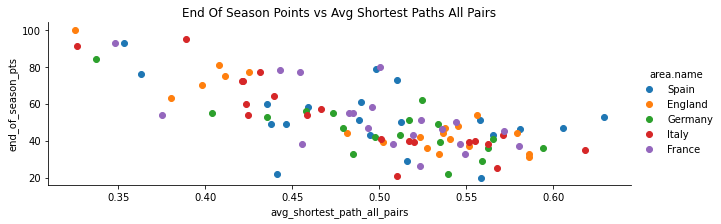

<Figure size 432x288 with 0 Axes>

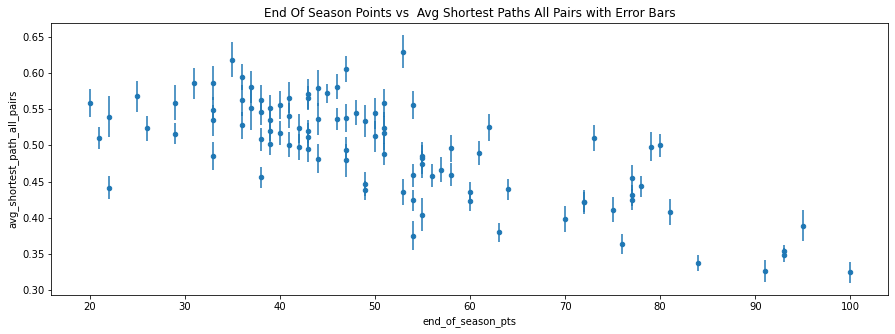

In [64]:
display(tmp[['avg_shortest_path_all_pairs', 'end_of_season_pts']].corr())

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'avg_shortest_path_all_pairs', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points vs Avg Shortest Paths All Pairs')
#plt.text(5, 85,'$\\rho$=0.56', fontsize=18)
plt.savefig('../figures/player_network_alg/avg_shortest_path_all_pairs_performance_EOS_pts', bbox_inches='tight')
plt.show()

plt.figure()
tmp[['avg_shortest_path_all_pairs', 'end_of_season_pts']].plot(kind='scatter', x='end_of_season_pts', y='avg_shortest_path_all_pairs', yerr=errors[['avg_shortest_path_all_pairs']], figsize=(15, 5))
plt.title('End Of Season Points vs  Avg Shortest Paths All Pairs with Error Bars')
plt.savefig('../figures/player_network_alg/avg_shortest_path_all_pairs_performance_EOS_pts_ERROR', bbox_inches='tight')

plt.show()